# LIBARY

In [1]:
!nvidia-smi

Wed Jul 15 17:49:54 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/My Drive/PPNCKH

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive/PPNCKH


In [3]:
import cv2
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import pandas as pd

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from tensorflow.keras.callbacks import *

In [4]:
INIT_LR = 1e-4
EPOCHS = 40
BS = 8
tta_times = 10
imgSize = 512

# IMG PREPROCESSING

In [5]:
def change_brightness(img):
    value = random.randint(-10,15)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    
    v = cv2.add(v,value)
    v[v > 255] = 255
    v[v < 0] = 0
    
    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img

In [6]:
def preprocessing(img):
    img = change_brightness(img)
    return img

# LOAD

In [7]:
trainAug = ImageDataGenerator(rotation_range=20, 
                              horizontal_flip = True,
                              shear_range=0.1,
                              channel_shift_range = 0.05,
                              fill_mode="constant", 
                              rescale=1./255,
                              preprocessing_function = preprocessing,
                              validation_split=0.2)

testAug = ImageDataGenerator( rescale=1./255,
                              validation_split=0.2)

In [8]:
train_generator = trainAug.flow_from_directory('cropped/',
                                               target_size=(imgSize, imgSize),
                                               batch_size=BS,
                                               class_mode='categorical', 
                                               subset='training')

test_generator = testAug.flow_from_directory('cropped/',
                                              target_size=(imgSize, imgSize),
                                              batch_size=BS,
                                              class_mode='categorical', 
                                              subset='validation')

Found 2325 images belonging to 3 classes.
Found 580 images belonging to 3 classes.


# MODEL

In [9]:
baseModel = DenseNet201(weights="imagenet", include_top=False, input_tensor=Input(shape=(imgSize, imgSize, 3)))
headModel = baseModel.output
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="elu")(headModel)
headModel = Dense(16, activation="elu")(headModel)
headModel = Dense(3, activation="softmax")(headModel)
model = Model(inputs=baseModel.input, outputs=headModel)
for layer in baseModel.layers:
    layer.trainable = True

74842112/74836368 [==============================] - 3s 0us/step


In [10]:
best_val_acc = 0
best_train_acc = 0
def saveModel(epoch,logs):
    val_acc = logs['val_accuracy']
    train_acc = logs['accuracy']
    global best_val_acc
    global best_train_acc

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        model.save('model_densenet201_v4.h5')
    elif val_acc == best_val_acc:
        if train_acc > best_train_acc:
            best_train_acc= train_acc
            model.save('model_densenet201_v4.h5')

In [11]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
H = model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.samples // BS,
    validation_data=test_generator,
    validation_steps=test_generator.samples // BS,
    callbacks= [LambdaCallback(on_epoch_end=saveModel),
#              EarlyStopping(monitor='val_accuracy', patience=3),
#              ReduceLROnPlateau(monitor='val_accuracy', factor=0.5,patience=4),
              ],
    epochs=EPOCHS)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/40
290/290 [==============================] - 1664s 6s/step - loss: 0.6411 - accuracy: 0.8606 - val_loss: 1.6684 - val_accuracy: 0.5399
Epoch 2/40
290/290 [==============================] - 261s 899ms/step - loss: 0.2666 - accuracy: 0.9193 - val_loss: 0.2314 - val_accuracy: 0.9479
Epoch 3/40
290/290 [==============================] - 248s 856ms/step - loss: 0.1842 - accuracy: 0.9413 - val_loss: 0.8801 - val_accuracy: 0.7674
Epoch 4/40
290/290 [==============================] - 245s 844ms/step - loss: 0.1017 - accuracy: 0.9707 - val_loss: 1.2784 - val_accuracy: 0.7587
Epoch 5/40
290/290 [==============================] - 245s 843ms/step - loss: 0.0838 - accuracy: 0.9724 - val_loss: 2.5538 - val_accuracy: 0.5260
Epoch 6/40
290/290 [==============================] - 244s 841ms/step - loss: 0.1108 - accuracy: 0.9646 - val_loss: 0.1591 - val_accuracy: 0.9410
Epoch 7/40
290/290 [==============================

KeyboardInterrupt: ignored

In [ ]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

# TEST

In [12]:
model= load_model('model_densenet201_v4.h5')

In [13]:
def wrong_to_list(preds, generator):
    res = []
    for i in range(len(preds)):
        if (preds[i] != generator.labels[i]):
            res.append(generator.filenames[i])
    return res

def show_wrong_img(l):
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(24, 10))
    ten_random_samples = pd.Series(l).sample(min(len(l),10)).values
    
    for idx, image in enumerate(ten_random_samples):
        final_path = os.path.join('cropped/', image)
        img = cv2.imread(final_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes.ravel()[idx].imshow(img)
        axes.ravel()[idx].axis('off')
    plt.tight_layout()

## WITHOT TTA

### ON TRAIN

In [14]:
train = ImageDataGenerator(rescale=1./255,
                           validation_split=0.2).flow_from_directory('cropped/',
                                                                     target_size=(imgSize, imgSize),
                                                                     batch_size=BS,
                                                                     class_mode='categorical',
                                                                     shuffle = False,
                                                                     subset='training')

Found 2325 images belonging to 3 classes.


In [15]:
CName = {v: k for k, v in train.class_indices.items()}
predIdxs = model.predict_generator(train)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(train.labels, predIdxs, target_names=list(train.class_indices.keys()), digits = 5))

Instructions for updating:
Please use Model.predict, which supports generators.
                 precision    recall  f1-score   support

       COVID-19    1.00000   1.00000   1.00000       176
         NORMAL    1.00000   0.99068   0.99532      1073
Viral Pneumonia    0.99079   1.00000   0.99537      1076

       accuracy                        0.99570      2325
      macro avg    0.99693   0.99689   0.99690      2325
   weighted avg    0.99574   0.99570   0.99570      2325



In [16]:
for i in range(len(predIdxs)):
    if (predIdxs[i] != train.labels[i]):
        print('Filename:',train.filenames[i].split('/')[1], '\t'*(5-math.ceil((len(train.filenames[i].split('/')[1])+3)/8)) +'PRED:', CName[predIdxs[i]], '\t'*(4-(3+len(CName[predIdxs[i]]))//8) + 'TRUE:', CName[train.labels[i]])

Filename: NORMAL (1277).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Filename: NORMAL (1325).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Filename: NORMAL (1335).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Filename: NORMAL (152).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Filename: NORMAL (840).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Filename: NORMAL (843).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Filename: NORMAL (844).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Filename: NORMAL (845).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Filename: NORMAL (848).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Filename: NORMAL (862).png 		PRED: Viral Pneumonia 		TRUE: NORMAL


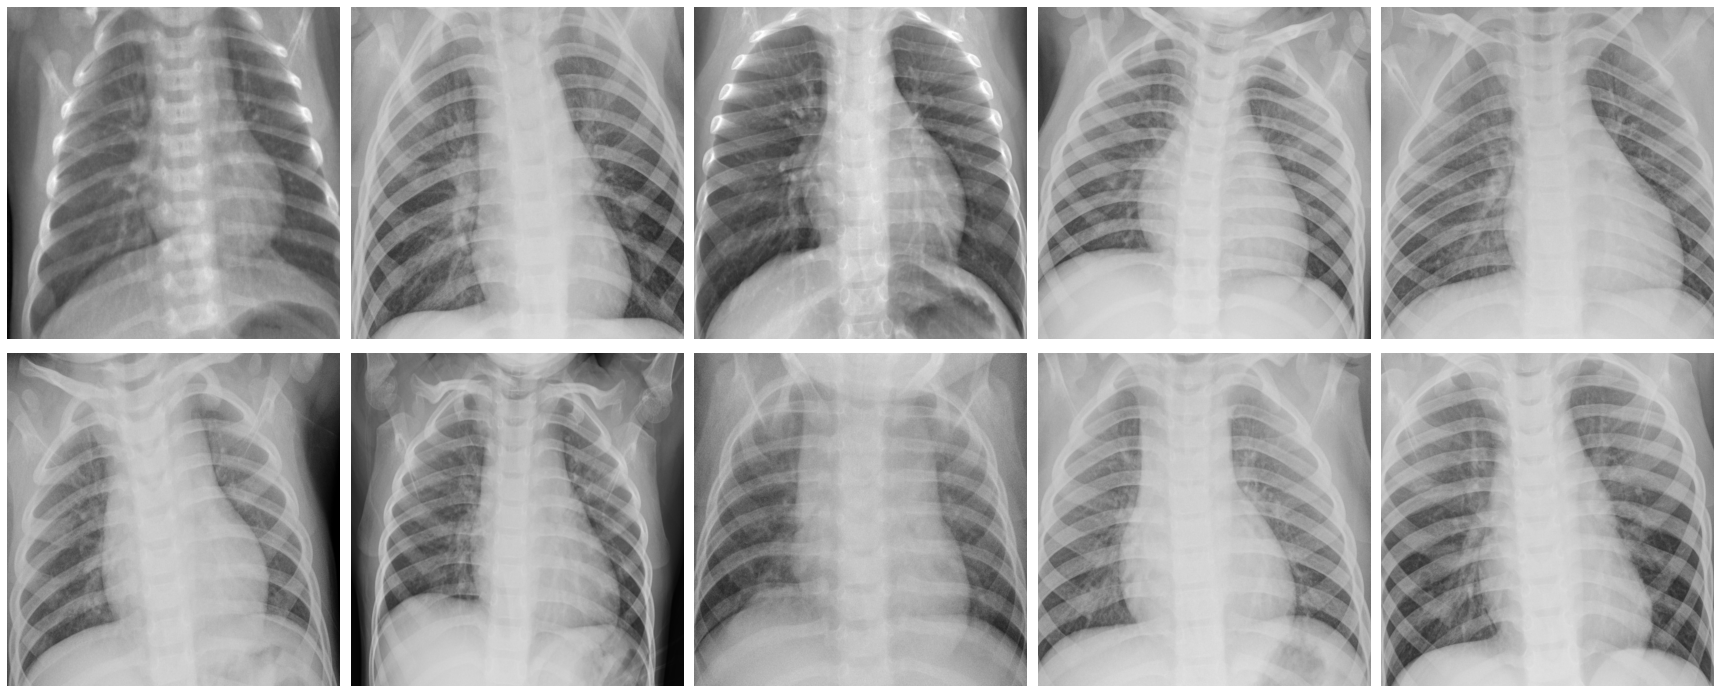

In [17]:
show_wrong_img(wrong_to_list(predIdxs, train))

### ON TEST

In [18]:
test = ImageDataGenerator(rescale=1./255, 
                          validation_split=0.2).flow_from_directory('cropped/',
                                                                    target_size=(imgSize, imgSize),
                                                                    batch_size=BS,
                                                                    class_mode='categorical', 
                                                                    shuffle = False, 
                                                                    subset='validation')

Found 580 images belonging to 3 classes.


In [19]:
CName = {v: k for k, v in test.class_indices.items()}
predIdxs = model.predict_generator(test, verbose=1)
predIdxs = np.argmax(predIdxs, axis=1)

73/73 [==============================] - 18s 240ms/step


In [20]:
print(classification_report(test.labels, predIdxs, target_names=list(test.class_indices.keys()), digits = 5))

                 precision    recall  f1-score   support

       COVID-19    1.00000   1.00000   1.00000        43
         NORMAL    0.99618   0.97388   0.98491       268
Viral Pneumonia    0.97455   0.99628   0.98529       269

       accuracy                        0.98621       580
      macro avg    0.99024   0.99005   0.99007       580
   weighted avg    0.98643   0.98621   0.98620       580



In [21]:
for i in range(len(predIdxs)):
    if (predIdxs[i] != test.labels[i]):
        print('Filename:',test.filenames[i].split('/')[1], '\t'*(5-math.ceil((len(test.filenames[i].split('/')[1])+3)/8)) +'PRED:', CName[predIdxs[i]], '\t'*(4-(3+len(CName[predIdxs[i]]))//8) + 'TRUE:', CName[test.labels[i]])

Filename: NORMAL (1075).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Filename: NORMAL (1088).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Filename: NORMAL (1089).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Filename: NORMAL (1092).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Filename: NORMAL (1149).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Filename: NORMAL (1206).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Filename: NORMAL (1230).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Filename: Viral Pneumonia (1237).png 	PRED: NORMAL 			TRUE: Viral Pneumonia


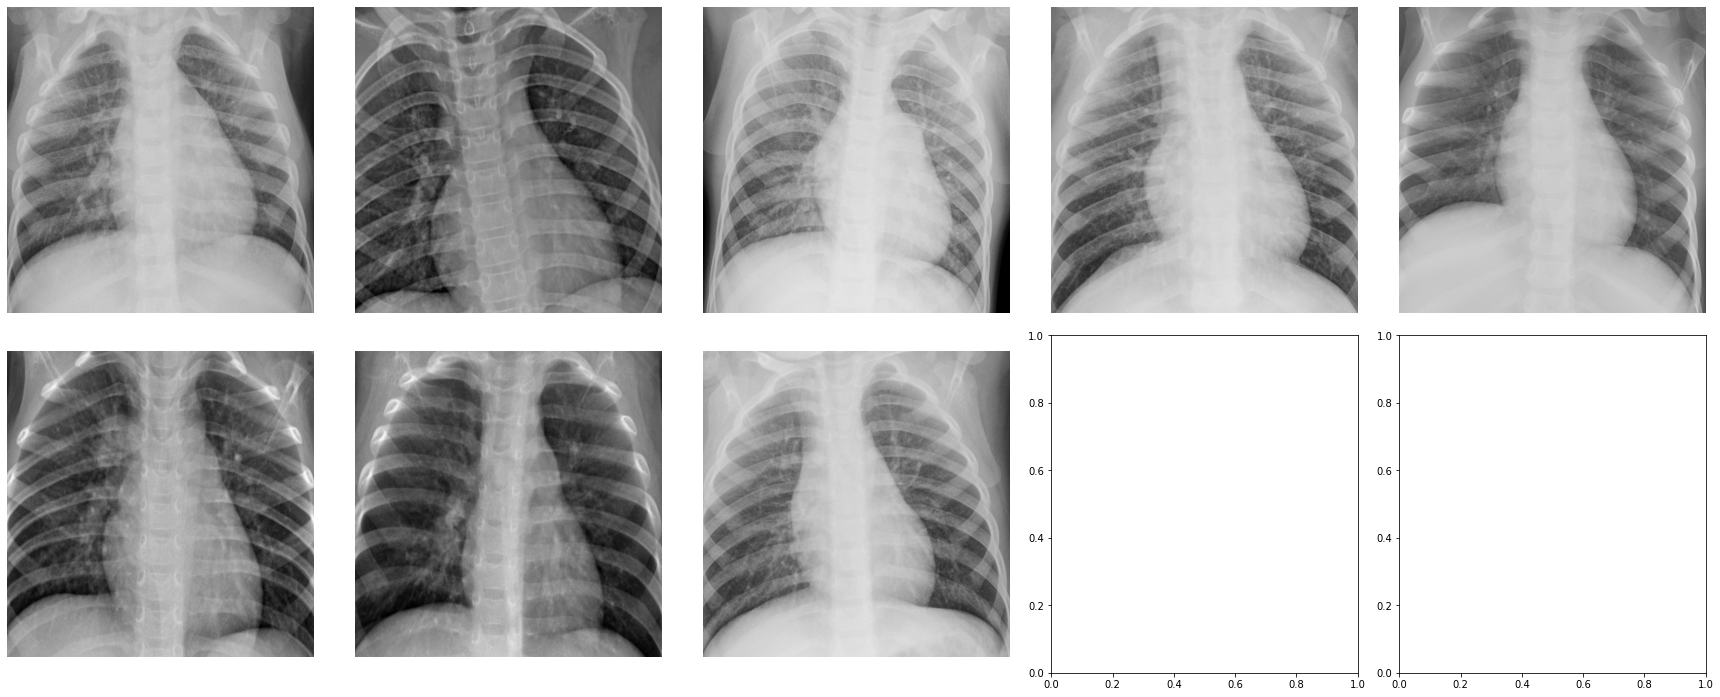

In [22]:
show_wrong_img(wrong_to_list(predIdxs, test))

## WITH TTA

### ON TRAIN

In [55]:
train = ImageDataGenerator(horizontal_flip = True,
                          fill_mode="constant", 
                          rescale=1./255,
                          preprocessing_function = preprocessing,
                          validation_split=0.2).flow_from_directory('cropped/',
                                                                     target_size=(imgSize, imgSize),
                                                                     batch_size=BS,
                                                                     class_mode='categorical',
                                                                     shuffle = False,
                                                                     subset='training')
CName = {v: k for k, v in train.class_indices.items()}
probabilities = []
for i in range(tta_times):
    print('TTA Number: ', i, '\n')
    probabilities.append(model.predict(train, verbose=1))
predIdxs = np.mean(probabilities, axis=0)
predIdxs = np.argmax(predIdxs, axis=1)

Found 2325 images belonging to 3 classes.
TTA Number:  0 

291/291 [==============================] - 70s 241ms/step
TTA Number:  1 

291/291 [==============================] - 69s 237ms/step
TTA Number:  2 

291/291 [==============================] - 68s 235ms/step
TTA Number:  3 

291/291 [==============================] - 68s 235ms/step
TTA Number:  4 

291/291 [==============================] - 68s 235ms/step
TTA Number:  5 

291/291 [==============================] - 68s 235ms/step
TTA Number:  6 

291/291 [==============================] - 68s 234ms/step
TTA Number:  7 

291/291 [==============================] - 69s 236ms/step
TTA Number:  8 

291/291 [==============================] - 68s 233ms/step
TTA Number:  9 

291/291 [==============================] - 69s 237ms/step


In [56]:
print(classification_report(train.labels, predIdxs, target_names=list(train.class_indices.keys()), digits = 5))

                 precision    recall  f1-score   support

       COVID-19    1.00000   1.00000   1.00000       176
         NORMAL    1.00000   0.99161   0.99579      1073
Viral Pneumonia    0.99171   1.00000   0.99584      1076

       accuracy                        0.99613      2325
      macro avg    0.99724   0.99720   0.99721      2325
   weighted avg    0.99616   0.99613   0.99613      2325



In [57]:
for i in range(len(predIdxs)):
    if (predIdxs[i] != train.labels[i]):
        print('Filename:',train.filenames[i].split('/')[1], '\t'*(5-math.ceil((len(train.filenames[i].split('/')[1])+3)/8)) +'PRED:', CName[predIdxs[i]], '\t'*(4-(3+len(CName[predIdxs[i]]))//8) + 'TRUE:', CName[train.labels[i]])

Filename: NORMAL (1277).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Filename: NORMAL (1325).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Filename: NORMAL (152).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Filename: NORMAL (840).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Filename: NORMAL (843).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Filename: NORMAL (844).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Filename: NORMAL (845).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Filename: NORMAL (848).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Filename: NORMAL (862).png 		PRED: Viral Pneumonia 		TRUE: NORMAL


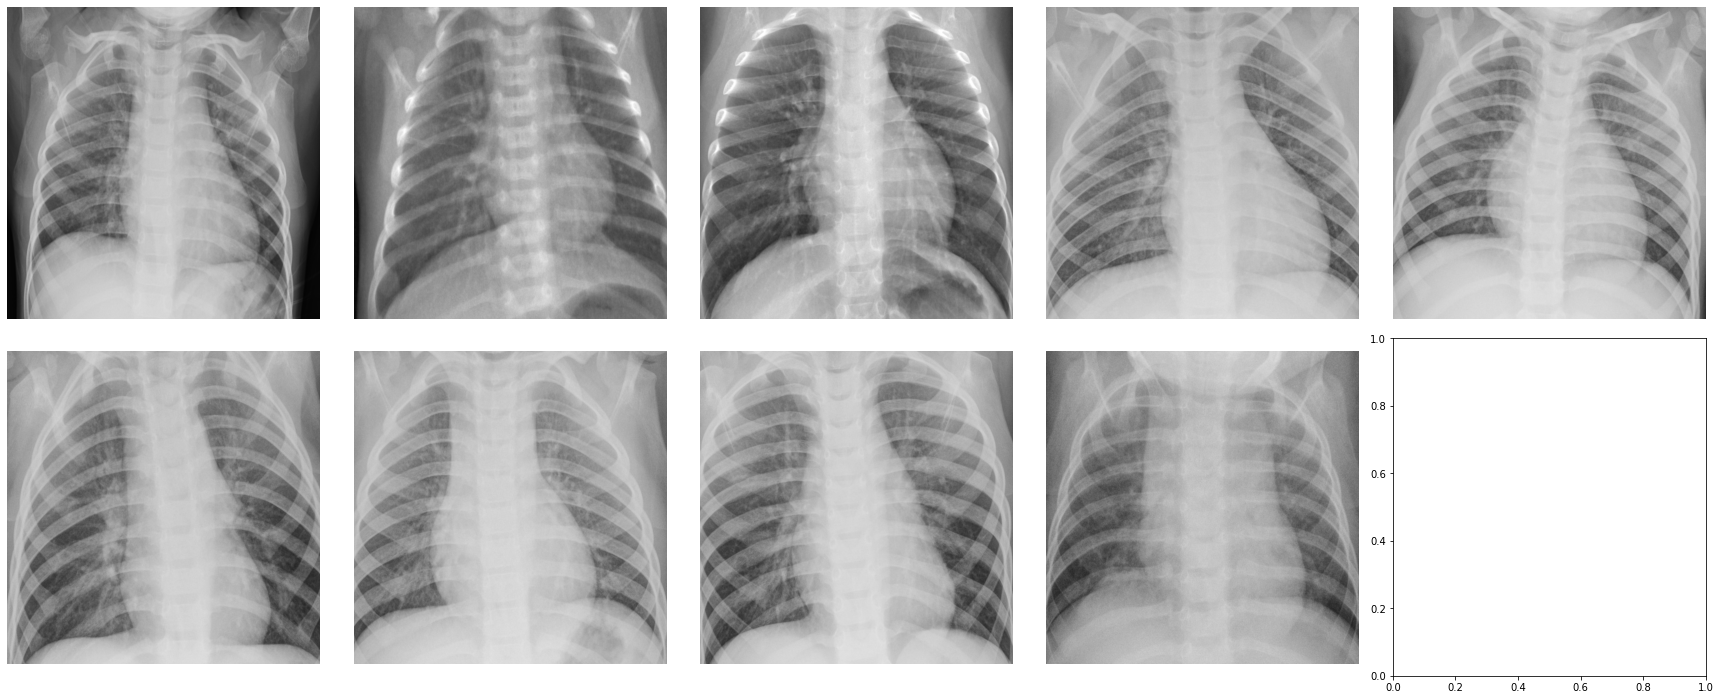

In [58]:
show_wrong_img(wrong_to_list(predIdxs, train))

### ON TEST

In [59]:
test = ImageDataGenerator(horizontal_flip = True,
                          fill_mode="constant", 
                          rescale=1./255,
                          preprocessing_function = preprocessing,
                          validation_split=0.2).flow_from_directory('cropped/',
                                                                    target_size=(imgSize, imgSize),
                                                                    batch_size=BS,
                                                                    class_mode='categorical', 
                                                                    shuffle = False, 
                                                                    subset='validation')
CName = {v: k for k, v in test.class_indices.items()}
probabilities = []
for i in range(tta_times):
    print('TTA Number: ', i, '\n')
    probabilities.append(model.predict(test, verbose=1))
predIdxs = np.mean(probabilities, axis=0)
predIdxs = np.argmax(predIdxs, axis=1)

Found 580 images belonging to 3 classes.
TTA Number:  0 

73/73 [==============================] - 17s 231ms/step
TTA Number:  1 

73/73 [==============================] - 17s 234ms/step
TTA Number:  2 

73/73 [==============================] - 17s 231ms/step
TTA Number:  3 

73/73 [==============================] - 17s 232ms/step
TTA Number:  4 

73/73 [==============================] - 17s 234ms/step
TTA Number:  5 

73/73 [==============================] - 17s 231ms/step
TTA Number:  6 

73/73 [==============================] - 17s 233ms/step
TTA Number:  7 

73/73 [==============================] - 17s 230ms/step
TTA Number:  8 

73/73 [==============================] - 17s 234ms/step
TTA Number:  9 

73/73 [==============================] - 17s 232ms/step


In [60]:
print(classification_report(test.labels, predIdxs, target_names=list(test.class_indices.keys()), digits = 5))

                 precision    recall  f1-score   support

       COVID-19    1.00000   1.00000   1.00000        43
         NORMAL    0.99618   0.97388   0.98491       268
Viral Pneumonia    0.97455   0.99628   0.98529       269

       accuracy                        0.98621       580
      macro avg    0.99024   0.99005   0.99007       580
   weighted avg    0.98643   0.98621   0.98620       580



In [61]:
for i in range(len(predIdxs)):
    if (predIdxs[i] != test.labels[i]):
        print('Filename:',test.filenames[i].split('/')[1], '\t'*(5-math.ceil((len(test.filenames[i].split('/')[1])+3)/8)) +'PRED:', CName[predIdxs[i]], '\t'*(4-(3+len(CName[predIdxs[i]]))//8) + 'TRUE:', CName[test.labels[i]])

Filename: NORMAL (1075).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Filename: NORMAL (1088).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Filename: NORMAL (1089).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Filename: NORMAL (1092).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Filename: NORMAL (1149).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Filename: NORMAL (1206).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Filename: NORMAL (1230).png 		PRED: Viral Pneumonia 		TRUE: NORMAL
Filename: Viral Pneumonia (1237).png 	PRED: NORMAL 			TRUE: Viral Pneumonia


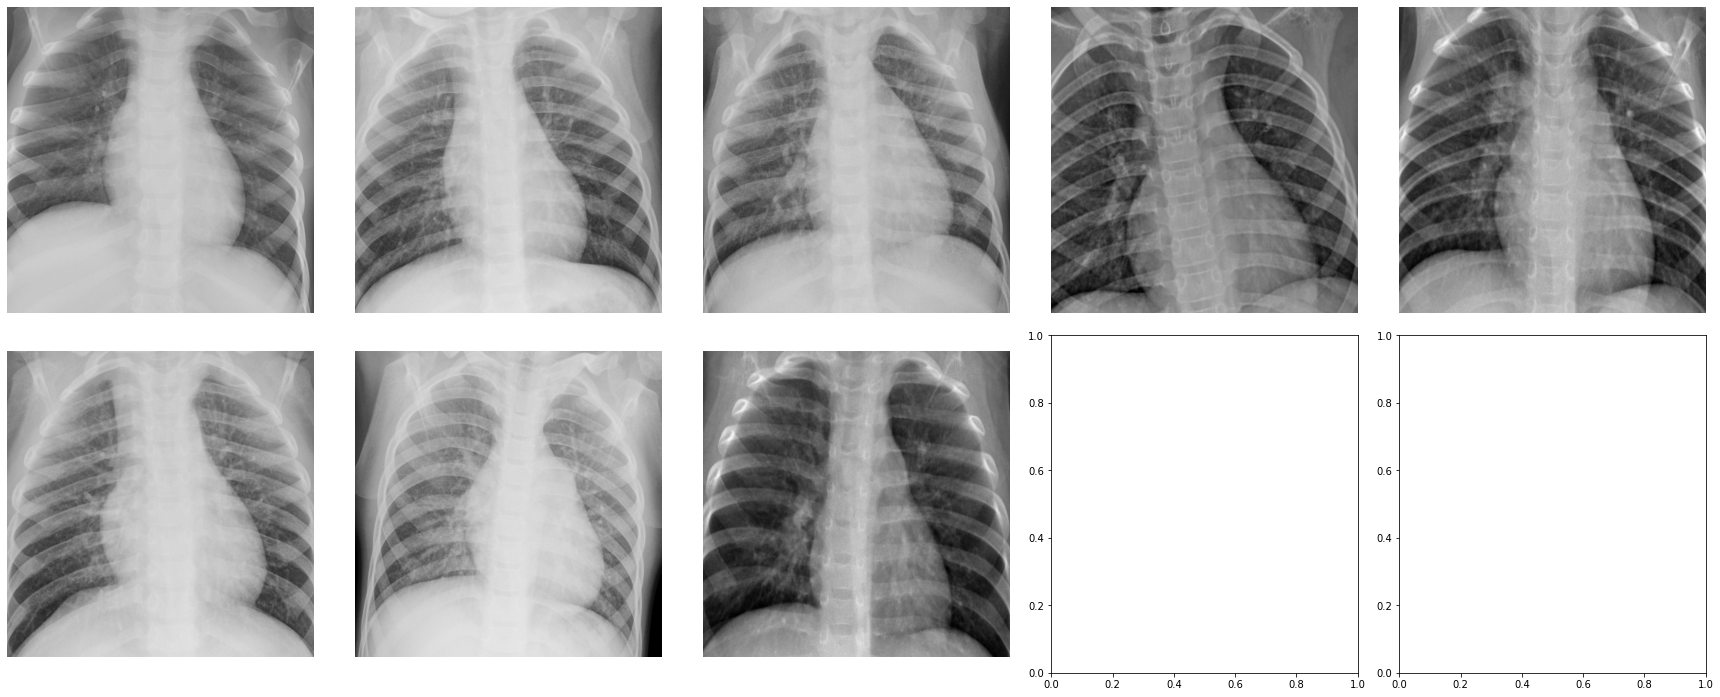

In [62]:
show_wrong_img(wrong_to_list(predIdxs, test))